In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from utils import set_seed, load_dataset, plot_feature_maps, plot_training_progress, evaluate_model
from transform import TensorAugment, SimpleResize
from models import WDMClassifierTiny, WDMClassifierMedium
from sklearn.metrics import accuracy_score

In [26]:
cdm_model='SIMBA'

cdm_file=f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/{cdm_model}/Maps_Mtot_{cdm_model}_LH_z=0.00.npy'
wdm_file='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy'

# Sample indices
all_indices = random.sample(range(15000), 1000)
random.shuffle(all_indices)



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = WDMClassifierMedium().to(device)
checkpoint = torch.load("best_cnn_model_blur_0_medium.pt", map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

WDMClassifierMedium(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(256, 25

In [28]:
sigmas = np.concatenate([np.linspace(0.0,0.5,10),np.linspace(0.25,0.29,10),np.linspace(0.29,0.35,10)])
sorted_idx = np.argsort(sigmas)
sigmas = sigmas[sorted_idx]
acc = []

In [29]:
for s in sigmas:
    
    blur_transform = TensorAugment(
        size=(256, 256),
        p_flip=0.0, # No flipping and rotation for now
        p_rot=0.0,
        noise_std=0, # Stop noise temporarily
        blur_sigma=s,
        apply_log=True,  # Keep log scale
        normalize=False  # Normalize images to [0, 1]
    )
    
    
    test_dataset = load_dataset(all_indices, transform=blur_transform, cdm_file=cdm_file, wdm_file=wdm_file)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, 
                             num_workers=1, pin_memory=True)
    
    # --- Inference and Feature Extraction ---
    all_preds, all_labels, features, softscores = [], [], [], []
    
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
    
            # Feature extraction
            feats = model.features(x)
            pooled = nn.AdaptiveAvgPool2d((1, 1))(feats)  # [B, 128, 1, 1]
            flat_feats = torch.flatten(pooled, 1)         # [B, 128]
    
            # Classifier
            logits = model.classifier[3](flat_feats).squeeze(1)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
    
            # Store outputs
            features.append(flat_feats.cpu())
            softscores.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    features = torch.cat(features, dim=0).numpy()
    softscores = np.array(softscores)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # --- Compute Accuracy ---
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Blur sigma {s} Accuracy: {accuracy:.5f}")
    
    acc.append(accuracy)
    with open('acc_vs_sigma.txt','a') as file:
        file.write(f'{cdm_model} {s:.6f} {accuracy:.6f}\n')
    
acc = np.asarray(acc)

Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/SIMBA/Maps_Mtot_SIMBA_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy...
WDM data shape: (15360, 256, 256)
Created dataset with 2000 samples
Blur sigma 0.0 Accuracy: 0.73000
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/SIMBA/Maps_Mtot_SIMBA_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy...
WDM data shape: (15360, 256, 256)
Created dataset with 2000 samples
Blur sigma 0.05555555555555555 Accuracy: 0.73000
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/SIMBA/Maps_Mtot_SIMBA_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG

<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2918774/2607542230.py:63: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('Gaussian blur $\sigma$')
/tmp/ipykernel_2918774/2607542230.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


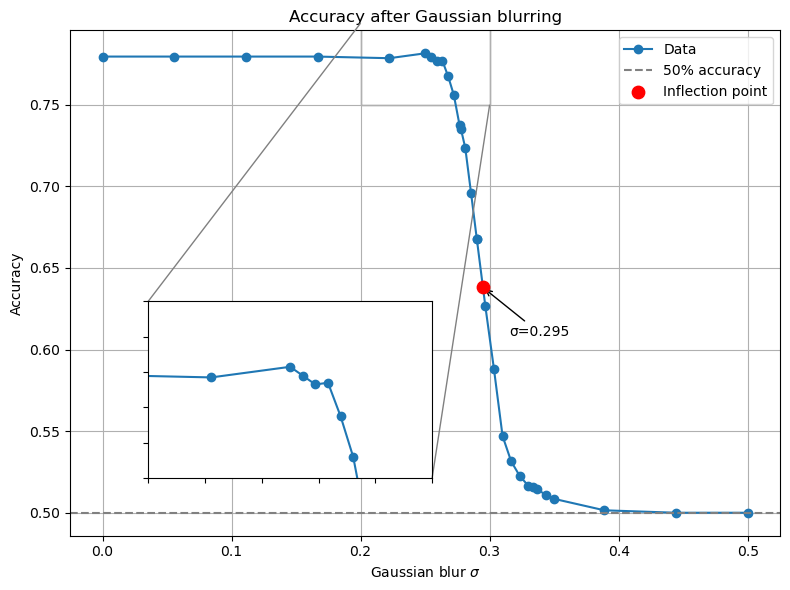

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# --- Data ---
x = np.array(sigmas)
y = np.array(acc)

# --- Interpolation ---
spline = UnivariateSpline(x, y, s=1e-4)
x_dense = np.linspace(x.min(), x.max(), 1000)
y_dense = spline(x_dense)
d2y = spline.derivative(n=2)(x_dense)

# --- Inflection points ---
inflection_indices = np.where(np.diff(np.sign(d2y)))[0]
inflect_xs = x_dense[inflection_indices]
inflect_ys = y_dense[inflection_indices]

# Optionally select one for main highlight
if len(inflection_indices) >= 3:
    idx = inflection_indices[2]
    main_inflect_x = x_dense[idx]
    main_inflect_y = y_dense[idx]
else:
    main_inflect_x = main_inflect_y = None

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(8, 6))

# --- Main plot ---
ax.plot(x, y, marker='o', label='Data')
ax.axhline(0.5, color='gray', linestyle='dashed', label='50% accuracy')

# Highlight one chosen inflection
if main_inflect_x is not None:
    ax.scatter([main_inflect_x], [main_inflect_y], color='red', s=80, zorder=5, label='Inflection point')
    ax.annotate(f'σ={main_inflect_x:.3f}', xy=(main_inflect_x, main_inflect_y),
                xytext=(main_inflect_x + 0.02, main_inflect_y - 0.03),
                arrowprops=dict(facecolor='red', arrowstyle='->'))

# --- Inset zoom plot ---
axins = inset_axes(ax, width="50%", height="70%", loc='lower left', 
                   bbox_to_anchor=(0.1, 0.1, 0.8, 0.5), bbox_transform=ax.transAxes)

# Inset content
axins.plot(x, y, marker='o')

# Inset zoom limits
x1, x2 = 0.2, 0.3
y1, y2 = 0.75, 0.8
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Turn off tick labels for inset for cleaner look
axins.tick_params(labelleft=False, labelbottom=False)

# Mark zoom region
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# --- Final touches ---
ax.set_xlabel('Gaussian blur $\sigma$')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy after Gaussian blurring')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.savefig('blur.png')
plt.show()


In [30]:
data = []
with open('acc_vs_sigma.txt','r') as f:
    for line in f.readlines():
        data.append(line.strip().split(' '))

data=np.asarray(data)

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2918774/3231080639.py:15: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Gaussian blur $\sigma$')


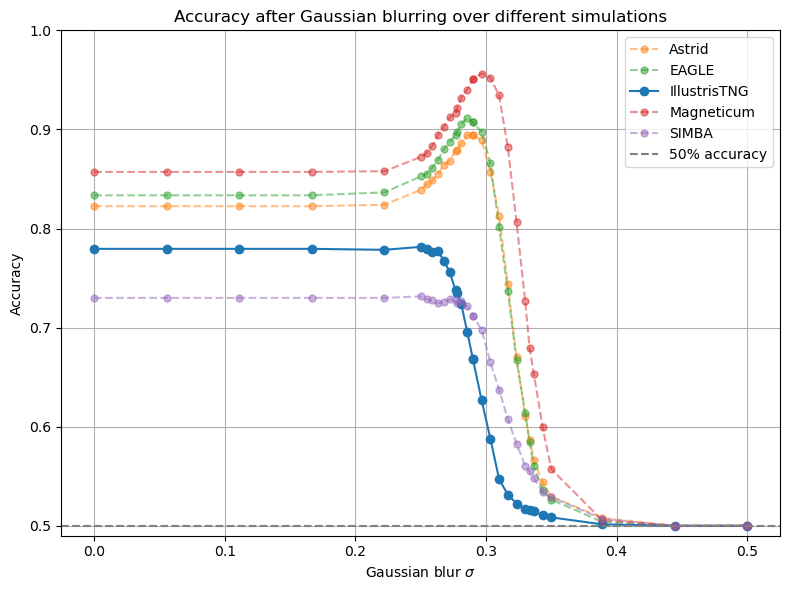

In [31]:
plt.subplots(figsize=(8, 6))

cs=['tab:orange','tab:green','tab:blue','tab:red','tab:purple']

for sim, c in zip(np.unique(data[:,0]),cs):
    d = data[np.where(sim==data[:,0]),1:][0].astype(float)
    if sim=='IllustrisTNG':
        plt.plot(d[:,0],d[:,1], marker='o',label=sim,linestyle='solid',color=c)
    else:
        plt.plot(d[:,0],d[:,1], marker='o',label=sim,ms=5,linestyle='dashed', alpha=0.5, color=c)

plt.axhline(0.5, color='gray', linestyle='dashed', label='50% accuracy')
plt.legend()
plt.ylim(0.49,1)
plt.xlabel('Gaussian blur $\sigma$')
plt.ylabel('Accuracy')
plt.title('Accuracy after Gaussian blurring over different simulations')
plt.grid('True')
plt.tight_layout()
plt.savefig('blur_sims.png')
plt.show()